In [1]:
%matplotlib inline
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
#import more_itertools as mit
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import csv
import pandas as pd
import json
from scipy.optimize import curve_fit
from scipy import stats
from pprint import pprint
from sklearn.metrics import r2_score
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.unicode'] = True

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
!radical-stack


  python               : 2.7.15
  pythonpath           : 
  virtualenv           : python2

  radical.analytics    : 0.70.0
  radical.entk         : 0.70.0
  radical.pilot        : 0.70.0
  radical.saga         : 0.70.0
  radical.utils        : 0.70.0



In [2]:
stage_0_units = pd.read_csv('../Data/units_durations_satge0.csv')
train_stage_0_units = stage_0_units
train_stage_0_units.reset_index(drop='index',inplace=True)

stage_1_units = pd.read_csv('../Data/units_durations_satge1.csv')
train_stage_1_units = stage_1_units
train_stage_1_units.reset_index(drop='index',inplace=True)


In [3]:
x0_vals = stage_0_units['ImageSize1'].values
y0_vals = stage_0_units['ImageSize2'].values
z0_vals = stage_0_units['TTX'].values

x1_vals = stage_1_units['ImageSize1'].values
y1_vals = stage_1_units['ImageSize2'].values
z1_vals = stage_1_units['TTX'].values

stage_0_units_comb = pd.DataFrame(columns=['TotalSize','TTX'])
stage_1_units_comb = pd.DataFrame(columns=['TotalSize','TTX'])

for i in range(len(stage_0_units)):
    x = stage_0_units.loc[i]['ImageSize1']
    y = stage_0_units.loc[i]['ImageSize2']
    ttx = stage_0_units.loc[i]['TTX']
    stage_0_units_comb.loc[len(stage_0_units_comb)] = [x + y, ttx]
    
for i in range(len(stage_1_units)):
    x = stage_1_units.loc[i]['ImageSize1']
    y = stage_1_units.loc[i]['ImageSize2']
    ttx = stage_1_units.loc[i]['TTX']
    stage_1_units_comb.loc[len(stage_1_units_comb)] = [x + y, ttx]

In [4]:
stage_0_units_comb.sort_values(by=['TotalSize'],inplace=True)

stage_0_units_comb.reset_index(drop='index',inplace=True)

stage_0_tasks3 = stage_0_units_comb.reset_index(drop='index')


train_stage_0_ranges = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])

for i in range(1024,5120,187): # This is 92% of the images there are ranges that have 0 samples after 10800KBs
    train_stage_0_ranges.loc[len(train_stage_0_ranges)] = [[i, i + 187],stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values,
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.mean(),
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.std(),
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.min(),
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.max(),
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values,
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.mean(),
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.std(),
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.min(),
                                                                        stage_0_tasks3[(i/1024.0 < stage_0_tasks3['TotalSize']) & (stage_0_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.max()]
    

In [5]:
def func_lin(x, a, b):
    return a * x + b

xdata = train_stage_0_ranges['SizeMean'].values
ydata = train_stage_0_ranges['TimeMean'].values
poptTillingDes1lin, pcovTillingDes1lin = curve_fit(func_lin,xdata,ydata)
y = func_lin(xdata, *poptTillingDes1lin)
s_test = np.sqrt(np.sum(np.power((train_stage_0_ranges['TimeMean'].values - y), 2))/(len(y)-2))
print 'Linear: R-squared', r2_score(train_stage_0_ranges['TimeMean'].values,y), '$S_{error}$', s_test
print 'Parameter Values', poptTillingDes1lin

Linear: R-squared 0.9340991998599963 $S_{error}$ 0.16053319709101635
Parameter Values [0.49935557 2.45096932]


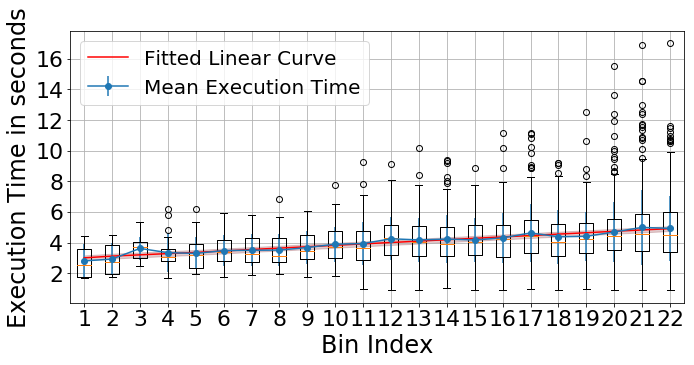

In [6]:
x = train_stage_0_ranges['SizeMean'].values

fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(11,5),sharey='row')
_ = axis.boxplot(train_stage_0_ranges['TimeArray'].values)
_ = axis.errorbar(range(1,23),train_stage_0_ranges['TimeMean'].values,yerr=train_stage_0_ranges['TimeStd'].values,marker='o',label='Mean Execution Time')
_ = axis.plot(range(1,23), y, 'r-', label="Fitted Linear Curve")
_ = axis.fill_between(range(1,23),y - s_test, y + s_test, color=reds(250), alpha=0.2)
_ = axis.set_ylabel('Execution Time in seconds',fontsize=24)
_ = axis.set_xlabel('Bin Index',fontsize=24)
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=22)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=22)
_ = axis.grid('on')
_ = axis.legend(fontsize=20)
#fig.savefig('../Data/des1_geo_stage_0_tx_box.pdf',dpi=800,bbox_inches='tight')

In [7]:
stage_1_units_comb.sort_values(by=['TotalSize'],inplace=True)

stage_1_units_comb.reset_index(drop='index',inplace=True)

stage_1_tasks3 = stage_1_units_comb.reset_index(drop='index')


train_stage_1_ranges = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])

for i in range(1024,5120,187): # This is 92% of the images there are ranges that have 0 samples after 10800KBs
    train_stage_1_ranges.loc[len(train_stage_1_ranges)] = [[i, i + 187],stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values,
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.mean(),
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.std(),
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.min(),
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TotalSize'].values.max(),
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values,
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.mean(),
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.std(),
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.min(),
                                                                        stage_1_tasks3[(i/1024.0 < stage_1_tasks3['TotalSize']) & (stage_1_tasks3['TotalSize'] < ((i + 187)/1024.0))]['TTX'].values.max()]

In [8]:
def func_lin(x, a, b):
    return a * x + b

xdata = train_stage_1_ranges['SizeMean'].values
ydata = train_stage_1_ranges['TimeMean'].values
poptTillingDes1lin, pcovTillingDes1lin = curve_fit(func_lin,xdata,ydata)
y = func_lin(xdata, *poptTillingDes1lin)
s_test = np.sqrt(np.sum(np.power((train_stage_1_ranges['TimeMean'].values - y), 2))/(len(y)-2))
print 'Linear: R-squared', r2_score(train_stage_1_ranges['TimeMean'].values,y), '$S_{error}$', s_test
print 'Parameter Values', poptTillingDes1lin

Linear: R-squared 0.7733175500408959 $S_{error}$ 0.02075506020797147
Parameter Values [0.03185806 0.87111368]


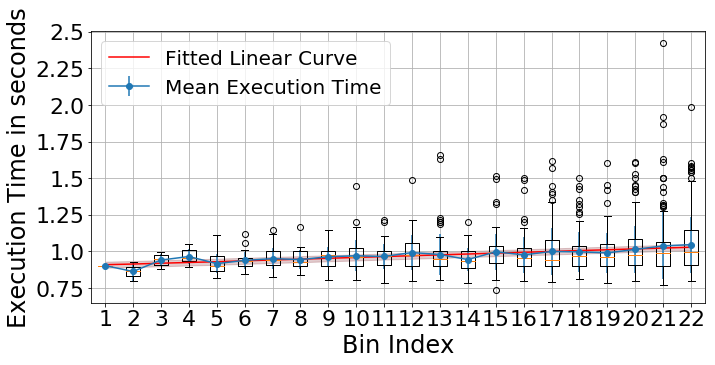

In [9]:
x = train_stage_1_ranges['SizeMean'].values

fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(11,5),sharey='row')
_ = axis.boxplot(train_stage_1_ranges['TimeArray'].values)
_ = axis.errorbar(range(1,23),train_stage_1_ranges['TimeMean'].values,yerr=train_stage_1_ranges['TimeStd'].values,marker='o',label='Mean Execution Time')
_ = axis.plot(range(1,23), y, 'r-', label="Fitted Linear Curve")
_ = axis.fill_between(range(1,23),y - s_test, y + s_test, color=reds(250), alpha=0.2)
_ = axis.set_ylabel('Execution Time in seconds',fontsize=24)
_ = axis.set_xlabel('Bin Index',fontsize=24)
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=22)
_ = axis.set_yticklabels(axis.get_yticks().astype('float').tolist(),fontsize=22)
_ = axis.grid('on')
_ = axis.legend(fontsize=20)
#fig.savefig('../Data/des1_geo_stage_1_tx_box.pdf',dpi=800,bbox_inches='tight')